In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

In [2]:
import os

import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224

data_dir = 'Spine/'

X = []
y = []
for folder in os.scandir(data_dir):
    print(folder)

    for entry in os.scandir(data_dir + folder.name):
        img = cv2.imread(data_dir + folder.name + '/' + entry.name, cv2.IMREAD_COLOR)  # Read image using OpenCV
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.array(img, dtype='float32')
        img = img / 255
        X.append(img)
        if folder.name == 'normal':
            y.append(0)
        elif folder.name == 'osteophenia':
            y.append(1)
        else:
            y.append(2)

X = np.array(X)
y = np.array(y)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

batch_size = 32
num_batches = 30  

augmented_images = []
augmented_labels = []
for _ in range(num_batches):
    X_batch, y_batch = next(datagen.flow(X, y, batch_size=batch_size, shuffle=False))
    augmented_images.append(X_batch)
    augmented_labels.append(y_batch)

X_aug= np.concatenate(augmented_images, axis=0)
y_aug = np.concatenate(augmented_labels, axis=0)
X_augu = np.concatenate((X, X_aug), axis=0)
y_augu=np.concatenate((y, y_aug), axis=0)


<DirEntry 'normal'>
<DirEntry 'osteophenia'>
<DirEntry 'osteoporosis'>


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

opt = Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

# Assuming X_augu and y_augu are already defined
X_train_val, X_test, y_train_val, y_test = train_test_split(X_augu, y_augu, test_size=0.2, shuffle=True, stratify=y_augu, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True, stratify=y_train_val, random_state=123)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, shuffle=True)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 861ms/step - accuracy: 0.7673 - loss: 5.9603 - val_accuracy: 0.9011 - val_loss: 0.2337
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 671ms/step - accuracy: 0.8821 - loss: 0.3203 - val_accuracy: 0.9011 - val_loss: 0.1700
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 667ms/step - accuracy: 0.9097 - loss: 0.1842 - val_accuracy: 0.9286 - val_loss: 0.1741
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 673ms/step - accuracy: 0.8818 - loss: 0.2360 - val_accuracy: 0.9341 - val_loss: 0.1655
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 672ms/step - accuracy: 0.9283 - loss: 0.1874 - val_accuracy: 0.9286 - val_loss: 0.1600
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 664ms/step - accuracy: 0.9152 - loss: 0.1865 - val_accuracy: 0.9176 - val_loss: 0.1506
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 665ms/step - accuracy: 0.9331 - loss: 0.1566 - val_accuracy: 0.9286 - val_loss: 0.1480
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 668ms/step - accuracy: 0.9213 - loss: 0.1701 - val_accu

In [7]:
model.save('Ravispine_MobileNetv2.h5')

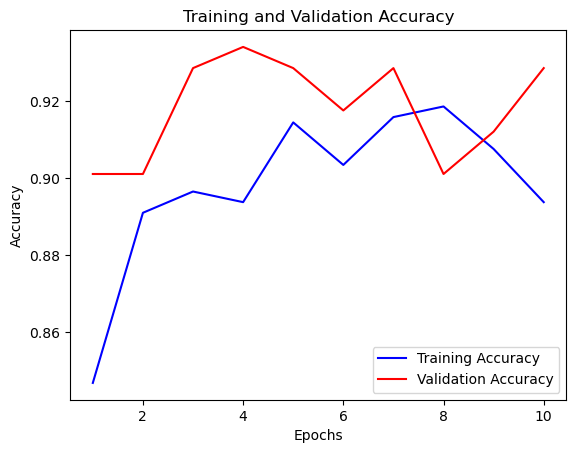

In [5]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [6]:

test_loss, test_accuracy = model.evaluate(X_val,y_val)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - accuracy: 0.9390 - loss: 0.1679
Test Loss: 0.14815886318683624
Test Accuracy: 0.9285714030265808
